# Random Walks Between Clusters

One interpretation of spectral clustering is that it seeks a partition of nodes which minimizes the probability that a random walker jumps between clusters. This is similar to RatioCut and similar to minimizing heat diffusion across clusters. In this notebook, we simulate a random walker and count the number of jumps between clusters.

In [1]:
from lib.spectral_clustering import spectral_clustering, laplacian_matrix, similarity_matrix
from lib.datasets import gaussian_mixture
from lib.kmeans import kmeans
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm
from tqdm import tqdm

## Data generation

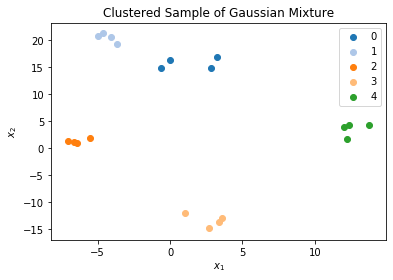

In [2]:
n_gaussians = 5
n_pts = 4
n = n_pts * n_gaussians
d = 2

data = gaussian_mixture(n_gaussians, n_pts, d, centroid_var=10)

cmap = cm.get_cmap("tab20")
unif_colors = [cmap(intensity) for intensity in np.linspace(0, 1, n)]

data_graph = similarity_matrix(data)
transition_matrix = data_graph / np.sum(data_graph, axis=1).reshape((-1, 1))

assns = spectral_clustering(data, k=n_gaussians, lform="rw")

data_clusters = [ data[assns == clss].T for clss in range(n_gaussians) ]
for j, data_cluster in enumerate(data_clusters):
    plt.scatter(*data_cluster, color=unif_colors[j], label=f"{j}")
    
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Clustered Sample of Gaussian Mixture")
plt.legend()
plt.savefig("artifacts/random_walk_clusters/Clustered_Sample_Gaussian.png", dpi=120)
plt.show()

## How often will a random walker move between clusters?


In [3]:
import numpy as np


def random_walks(transition_matrix, cluster_assns, iters=1000):
    # transition_matrix is nxn graph transition matrix
    # cluster_assns (n,) length vector assns

    n = len(transition_matrix) # number of nodes
    k = np.max(cluster_assns) + 1 # +1 to turn index to length
    
    rw_assns = np.arange(n)
    rw_cluster_assns = cluster_assns[rw_assns]
    jump_freqs = np.zeros((k, k))

    for i in range(iters):
        jump_likelihoods = transition_matrix[rw_assns]
        new_rw_assns = np.array([ np.random.choice(n, p=jump_likelihoods[i]) for i in range(n) ])
        new_cluster_assns = cluster_assns[new_rw_assns]
        
        
        
        cluster_jumps, counts = np.unique(np.stack((rw_cluster_assns, new_cluster_assns), axis=0), return_counts=True, axis=1)
        for i in range(len(counts)):
            r, c = cluster_jumps[:, i]
            jump_freqs[r, c] += counts[i]

        rw_cluster_assns = new_cluster_assns
        rw_assns = new_rw_assns
    return jump_freqs

jump_freqs = random_walks(transition_matrix, assns)

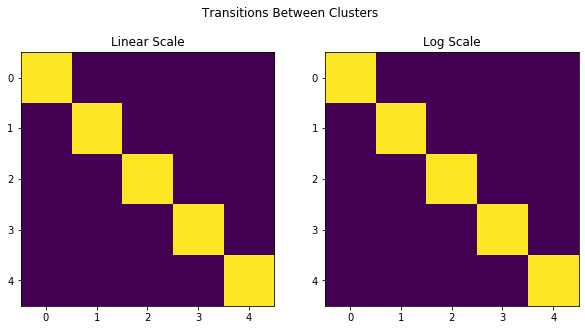

In [4]:
from matplotlib.ticker import MaxNLocator

plt.subplot(1, 2, 1)
plt.imshow(jump_freqs)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Linear Scale")

plt.subplot(1, 2, 2)
plt.imshow(np.log(jump_freqs + 10e-6))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Log Scale")

plt.suptitle("Transitions Between Clusters")
plt.gcf().set_size_inches(10,5)
plt.savefig("artifacts/random_walk_clusters/Transition Frequencies between Clusters.png", dpi=120)
plt.show()


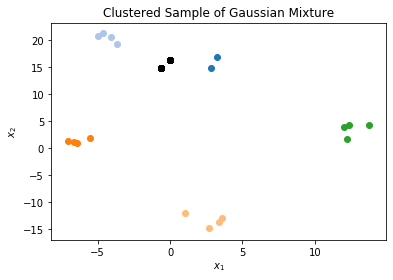

In [5]:
def random_walks_plot(transition_matrix, data, iters=50):
    # transition_matrix is nxn graph transition matrix
    # cluster_assns (n,) length vector assns

    n = len(transition_matrix) # number of nodes

    rw_assns = np.arange(n)
    walker = 0

    for i in range(iters):
        jump_likelihoods = transition_matrix[rw_assns]
        plt.scatter(*data[walker], color="k",label="walker")
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")
        plt.title("Clustered Sample of Gaussian Mixture")
        plt.savefig("artifacts/random_walk_clusters/walker_gif_pngs/image_step{:004d}.png".format(i))
       
        new_rw_assns = np.array([ np.random.choice(n, p=jump_likelihoods[i]) for i in range(n) ])
        walker = new_rw_assns[0]
        rw_assns = new_rw_assns

for j, data_cluster in enumerate(data_clusters):
    plt.scatter(*data_cluster, color=unif_colors[j], label=f"{j}")
random_walks_plot(transition_matrix, data)